![Make environment](makeEnv.png)

Image source: [here](https://about.make.org/about-environnement)

# Modélisation thématique
Dans ce projet nous allons appliquer le processus d'analyse de de texte, du prétraitement à la création des modèles thématiques et choix des thémes.

In [37]:
from util import *
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings('ignore')

In [2]:
# Quelques modules requises  

# ! pip install unidecod! pip install unidecode  
# ! pip install nltk  
# ! pip install gensim  
# ! pip install pyldavis   

# text   
# ! pip install spacy  
# ! pip install wordcloud  
# ! python3 -m spacy download fr_core_news_md  

## Lecture des données

In [3]:
with open("data_in/ensai2021_environnement.json", 'r') as file:
    raw_consultation = json.load(file) 

print('Loaded', len(raw_consultation), "entries")

Loaded 3 entries


### Exploration basic de la data

In [4]:
raw_consultation.keys()

dict_keys(['total', 'results', 'seed'])

In [5]:
raw_consultation["results"][0]

{'id': '72c5fa24-57b7-4b53-8c1a-b5e186ca7aa8',
 'userId': '8c88f320-4c78-416c-999a-be615e11d390',
 'content': "Il faut inciter les gens à visiter les usines de tri, d'incinération, et les sites d'enfouissement pour prendre conscience des déchets créés",
 'slug': 'il-faut-inciter-les-gens-a-visiter-les-usines-de-tri-d-incineration-et-les-sites-d-enfouissement-pour-prendre-conscience-des-dechets-crees',
 'status': 'Accepted',
 'createdAt': '2019-11-18T11:15:17.972Z',
 'updatedAt': '2019-11-21T17:12:47.580Z',
 'votes': [{'voteKey': 'agree',
   'count': 95,
   'qualifications': [{'qualificationKey': 'likeIt',
     'count': 11,
     'hasQualified': False},
    {'qualificationKey': 'doable', 'count': 36, 'hasQualified': False},
    {'qualificationKey': 'platitudeAgree', 'count': 6, 'hasQualified': False}],
   'hasVoted': False},
  {'voteKey': 'disagree',
   'count': 15,
   'qualifications': [{'qualificationKey': 'noWay',
     'count': 1,
     'hasQualified': False},
    {'qualificationKey': 

In [6]:
data = {}
for index, k in enumerate(raw_consultation["results"]):
    content = k.get("content")
    for i in k.get("votes"):
        if i["voteKey"] == "agree":
            # print(i.get("count"))
            count_vote_agree = i.get("count")
        if i["voteKey"] == "disagree":
            # print(i.get("count"))
            count_vote_disagree = i.get("count")
        if i["voteKey"] == "neutral":
            # print(i.get("count"))
            count_vote_neutral = i.get("count")
    data[index] = {'content' : content,
                    'count_vote_agree' : count_vote_agree, 
                    'count_vote_disagree' : count_vote_disagree, 
                    'count_vote_neutral' : count_vote_neutral}


In [7]:
data_toprocess = pd.DataFrame(data).T’

In [173]:
data_toprocess.shape

(9501, 10)

In [175]:
pd.DataFrame(data).T

,content,count_vote_agree,count_vote_disagree,count_vote_neutral
0,Il faut inciter les gens à visiter les usines ...,95,15,32
1,Il faut plus se déplacer en bus (voyage en com...,33,10,12
2,Il faut développer les transports en commun et...,39,8,6
3,Il faut supprimer les suremballages,144,6,7
4,"Il faut créer dans les magasins de proximité, ...",35,1,7
...,...,...,...,...
9496,Il faut éradiquer les insecticides et développ...,165,18,22
9497,"Il faut enlever l'eau potable des toilettes, l...",58,8,12
9498,Il faut interdire rapidement le maximum de pla...,400,13,15
9499,"Il faut aller nettoyer les océans, et solution...",26,1,3


### Creation des variables importantes

In [8]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/abdoulayediallo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [9]:
stop_words = set(stopwords.words('french'))

In [10]:
data_toprocess["content_len"] = data_toprocess['content'].str.len()
data_toprocess["word_count"] = data_toprocess['content'].str.split().map(lambda x: len(x))
data_toprocess["ponct_count"] = tweet_punc = data_toprocess['content'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
data_toprocess["upper_wr_count"] = data_toprocess["content"].apply(lambda x: sum(map(str.isupper, x.split())))

## Nettoyage du texte: stopwords, ponctuation, token,caractères unitules, chiffres

In [11]:
# Merci à https://www.kaggle.com/tanulsingh077 
def clean_text(text):
    ''' Normaliser en minuscules, supprimer le texte entre crochets, supprimer la ponctuation et supprimer les chiffres.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text


In [12]:
ilfaut = {"Il", "faut"}
stop_words.update(ilfaut)

In [13]:
import spacy
nlp = spacy.load('fr_core_news_md') 

In [14]:
def preprocess_data(text):
    """
    input: colonne texte
    output: La colonne texte netoyée(sasn ponct, stopwrds, ...)
    """
    # nettoyage des perturbateur
    text = clean_text(text)
    # stopwords
    text = ' '.join(word for word in text.split(' ') if word not in stop_words) 
    # Lemmas 
    # text = ' '.join(lemmatizer.lemmatize(word) for word in text.split(' '))
    text = " ".join([y.lemma_ for y in nlp(text)])
    
    return text

#
data_toprocess['content_clean'] = data_toprocess['content'].apply(preprocess_data)
data_toprocess['content_clean'] = data_toprocess['content_clean'].apply(lambda x: unidecode(x)) 
dataclean = data_toprocess.copy()

In [15]:
dataclean.sample(6)

,content,count_vote_agree,count_vote_disagree,count_vote_neutral,content_len,word_count,ponct_count,upper_wr_count,content_clean
7699,Il faut généraliser et rendre obligatoire le N...,18,1,8,74,11,0,0,generaliser rendre obligatoire nutriscor nivea...
7188,Il faut revoir le code pénal pour mieux protég...,86,12,25,84,14,0,0,revoir code penal mieux proteger animal domest...
5900,"Il faut interdire la vente de SUV, Crossover, ...",42,28,9,139,24,3,2,interdire vente suv crossover monospac obliger...
4080,Il faut que l'Etat donne des aides financières...,6,5,6,139,22,4,0,letat donne aide financier retrofit changement...
4755,Il faut pousser la banque européenne d'investi...,26,5,8,119,17,3,0,pousser banque europeen dinvestissement renonc...
2648,Il faut interdire aux industriels de créer et ...,23,2,2,123,17,2,0,interdire industriel creer mettre vente prod...


### N-grams

#### Voyons ce qu'on remarque en premier sur les texte et les mots les plus utilisés dasn cette consultation pour l'environmment.

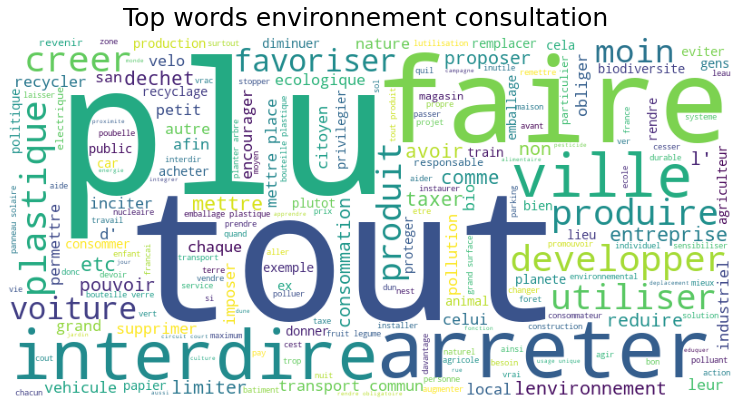

In [16]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS

wc = WordCloud(background_color='white', max_words=200, width=800, height=400)
wc.generate(' '.join(text for text in dataclean['content_clean'].values))

# plot
plt.figure(figsize=(13,10))
plt.title('Top words environnement consultation ', 
          fontdict={'size': 25,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()

<Figure size 432x288 with 0 Axes>

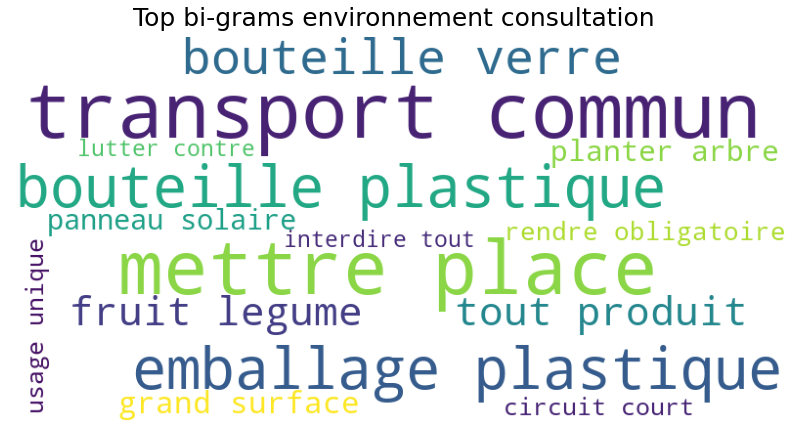

In [17]:

top_content_bigrams = get_top_ngrams(dataclean["content_clean"], n=2)[:15]

bag = dict(top_content_bigrams)
d = {}
for a, x in bag.items():
    d[a] = x
wc.generate_from_frequencies(frequencies=d)
plt.figure()
plt.figure(figsize=(14,10))
plt.title('Top bi-grams environnement consultation ', 
          fontdict={'size': 25,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()

**Standardisation des colonees numériques en (x-u)/sig**  
std_data = df.apply(lambda x: (x - np.mean(data_toprocess.content_len)) /   np.std(data_toprocess.content_len)) 

In [19]:
# We are going to create a document-term matrix using CountVectorizer, and exclude common English stop words
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer()
dataclean_cv = cv.fit_transform(dataclean.content_clean)
dataclean_dtm = pd.DataFrame(dataclean_cv.toarray(), columns=cv.get_feature_names())
dataclean_dtm.index = dataclean.index
dataclean_dtm

,aaa,ab,abaissement,abaisser,abandon,abandonne,abandonner,abattage,abattoir,abattoirs,...,za,zeppelin,zermatt,zero,zerodechet,zeroplastique,zi,zone,zoner,zoo
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9496,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9497,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9498,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9499,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
# Pickle
# les données peparées
dataclean.to_pickle('data_out/data_clean.pkl')

# doc term matrix data
dataclean_dtm.to_pickle("data_out/dataclean_dtm.pkl")

## PARTIE 2 Modélisation

### Basic exploration

La matrice termes-documents qui sert de point de départ est la suivante:

Dans cette partie, j'utilise Gensim(pour former la donnée et lda) et PyLDAvis(visualisation).  

|... | Mot 1         |  Mot 2     |   ...      | Mot n      | 
|:--:|:------------- | :----------:|:----------:| -----------:|
| Doc1   |  0             | 6           |    ---     |    0        |
| Doc2   |  4             | 1           |    ---     |    1        |
| ...   |  0             | 2           |    ---     |    0       |
| DocP   |  0             | 1           |    ---     |    0        |

La LDA consiste à transformer cette matrice sparse document-terme en deux matrices de moindre dimension:
* Une matrice document-sujet
* Une matrice sujet-mots

|... | K1         |  K 2     |   ...      | Kn      | 
|:--:|:------------- | :----------:|:----------:| -----------:|
| Doc1   |  0             | 6           |    ---     |    0        |
| Doc2   |  4             | 1           |    ---     |    1        |
| ...   |  0             | 2           |    ---     |    0       |
| DocP   |  0             | 1           |    ---     |    0        |  
**Une matrice document-sujet**

|... | Word1         |  Word 2     |   ...      | Word K      | 
|:--:|:------------- | :----------:|:----------:| -----------:|
| K1   |  0             | 6           |    ---     |    0        |
| K2   |  4             | 1           |    ---     |    1        |
| ...   |  0             | 2           |    ---     |    0       |
| Kn   |  0             | 1           |    ---     |    0        |  
**Une matrice sujet-mots**

**Ces deux matrices ont l’interprétation suivante :**
- La première nous renseigne sur la présence d’un sujet dans un document
- La seconde nous renseigne sur la présence d’un mot dans un sujet 

Source :[ nlp lda](https://linogaliana-teaching.netlify.app/nlp/lda/)

In [18]:
import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora

# docs de gensim: https://radimreh urek.com/gensim/utils.html#gensim.utils.simple_preprocess

def texte_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence)))

In [24]:
data =  data_toprocess.content_clean.values.tolist()
data_words = list(texte_to_words(data))

# creation du corpus
texts = data_words
# Gensim a besoin d'un dictionnaire de tous les termes et de leur emplacement respectif dans la matrice terme-document.
id2word = corpora.Dictionary(data_words)

# # Nous allons mettre nos donnée au format gensim, de df --> sparse matrix --> gensim corpus
corpus = [id2word.doc2bow(text) for text in texts]

# headers
[[(id2word[i], freq) for i, freq in doc] for doc in corpus[:3]]

[[('conscience', 1),
  ('creer', 1),
  ('dechet', 1),
  ('denfouissemer', 1),
  ('dincineration', 1),
  ('gens', 1),
  ('inciter', 1),
  ('prendre', 1),
  ('site', 1),
  ('tri', 1),
  ('usine', 1),
  ('visiter', 1)],
 [('bus', 1), ('commun', 1), ('deplacer', 1), ('plus', 1), ('voyage', 1)],
 [('commun', 1),
  ('developper', 1),
  ('donner', 1),
  ('fret', 1),
  ('sncf', 1),
  ('transport', 1)]]

## Baseline modèle:

### LDA

In [28]:
def ldamodel(df, textcol, numtopic):
    """
    Input: 
        - df: the data daframe, 
        - textcol: tokenized text in column in df,
        - numtopic: number of topic
    Output: 
        - lda model
    """
    data =  df[textcol].values.tolist()
    data_words = list(texte_to_words(data))

    # creation du corpus
    texts = data_words
    dico = corpora.Dictionary(data_words)
    dtm = [dico.doc2bow(text) for text in texts] # BOW

    # LDA model
    model = gensim.models.LdaMulticore(corpus = dtm,
                                       id2word = dico,
                                       num_topics = numtopic,
                                       iterations=512,
                                       passes=128)
    # print("viz des themes")
    # model.print_topics(5,10)
    return dtm, dico, model

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Modèle tentative 1

In [29]:
%time dtm, dico, lda1 =  ldamodel(dataclean, textcol='content_clean', numtopic=10)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


CPU times: user 1min 5s, sys: 7.96 s, total: 1min 13s
Wall time: 1min 40s


In [177]:
lda1.print_topics(5)

2021-05-12 12:05:26,069 : INFO : topic #9 (0.100): 0.024*"energie" + 0.019*"enfant" + 0.016*"plus" + 0.016*"nucleaire" + 0.014*"des" + 0.013*"lenvironnement" + 0.013*"jeune" + 0.011*"nature" + 0.010*"chasse" + 0.009*"developper"
2021-05-12 12:05:26,082 : INFO : topic #4 (0.100): 0.019*"public" + 0.014*"nuit" + 0.014*"interdire" + 0.013*"prendre" + 0.012*"tout" + 0.012*"court" + 0.010*"eteindre" + 0.010*"grand" + 0.009*"circuit" + 0.009*"taxer"
2021-05-12 12:05:26,088 : INFO : topic #6 (0.100): 0.055*"plastique" + 0.038*"emballage" + 0.029*"tout" + 0.022*"interdire" + 0.020*"produit" + 0.017*"supprimer" + 0.013*"non" + 0.012*"recyclable" + 0.010*"arreter" + 0.009*"recycler"
2021-05-12 12:05:26,090 : INFO : topic #2 (0.100): 0.038*"bouteille" + 0.028*"verre" + 0.019*"agriculteur" + 0.018*"plastique" + 0.017*"consigne" + 0.016*"remettre" + 0.014*"deau" + 0.013*"consigner" + 0.013*"revenir" + 0.010*"bio"
2021-05-12 12:05:26,091 : INFO : topic #8 (0.100): 0.013*"faire" + 0.013*"production" 

[(9,
  '0.024*"energie" + 0.019*"enfant" + 0.016*"plus" + 0.016*"nucleaire" + 0.014*"des" + 0.013*"lenvironnement" + 0.013*"jeune" + 0.011*"nature" + 0.010*"chasse" + 0.009*"developper"'),
 (4,
  '0.019*"public" + 0.014*"nuit" + 0.014*"interdire" + 0.013*"prendre" + 0.012*"tout" + 0.012*"court" + 0.010*"eteindre" + 0.010*"grand" + 0.009*"circuit" + 0.009*"taxer"'),
 (6,
  '0.055*"plastique" + 0.038*"emballage" + 0.029*"tout" + 0.022*"interdire" + 0.020*"produit" + 0.017*"supprimer" + 0.013*"non" + 0.012*"recyclable" + 0.010*"arreter" + 0.009*"recycler"'),
 (2,
  '0.038*"bouteille" + 0.028*"verre" + 0.019*"agriculteur" + 0.018*"plastique" + 0.017*"consigne" + 0.016*"remettre" + 0.014*"deau" + 0.013*"consigner" + 0.013*"revenir" + 0.010*"bio"'),
 (8,
  '0.013*"faire" + 0.013*"production" + 0.012*"leau" + 0.012*"vehicule" + 0.011*"arreter" + 0.010*"plus" + 0.010*"taxer" + 0.010*"consommation" + 0.010*"eau" + 0.007*"produire"')]

In [39]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

In [40]:
lda_display = gensimvis.prepare(lda1, dtm , dico, sort_topics=False, mds='mmds') # doc_term_matrix = corpus
pyLDAvis.display(lda_display)

**Remarque**: Ceci affiche les mot les plus fréquents, c'est à nous de les interpréter et de voir si les résultats ont un sens sinon essayer d'altérer les paramètres dans le terme document Matrix, nombre de themes, les nombre d'itérations, etc. et d'arrêter quand cela a du sens.

----------

**Remarque**  
Ces Thèmes ne sont pas très parlant. J'ai essayé de modifier les paramètres. Une remarque que je fais ici est que il  ya des mots qui revient de plus en plus et qui n'ont pas de sens ppour ce qu'on cherche. Donc je vais mettre à jours les stops words et les filter pour les prochain modèles.  

**Ajouter stopwords**: Exemple de mot: `tous`, `tout`, `faire`, `plus`, `moins`, 

**Essayer** Également de modifier la liste de termes à input au modèle.

--------------------

### Modèle tentative 2

#### Update stop_words

In [180]:
newstops = {'tous', 'tout', 'faire', 'plus', 'moins', 'car', 'cela', 'sans', 'non', 'etc', 'aaa', 'ab', 'afin'}
stop_words.update(newstops)

In [181]:
def round2process(text):
    """
    input: colonne texte
    output: La colonne texte netoyée(sasn ponct, stopwrds, ...)
    """
    # stopwords
    text = ' '.join(word for word in text.split(' ') if word not in stop_words) 
    
    return text

#
data_toprocess['content_clean_'] = data_toprocess['content_clean'].apply(round2process)
dataclean2 = data_toprocess.copy()

In [183]:
%time dtm, dico, lda2 = ldamodel(dataclean2, 'content_clean_', 4)

2021-05-12 12:15:45,997 : INFO : -7.850 per-word bound, 230.7 perplexity estimate based on a held-out corpus of 1501 documents with 11694 words
2021-05-12 12:15:45,998 : INFO : PROGRESS: pass 54, dispatched chunk #0 = documents up to #2000/9501, outstanding queue size 1
2021-05-12 12:15:46,001 : INFO : PROGRESS: pass 54, dispatched chunk #1 = documents up to #4000/9501, outstanding queue size 2
2021-05-12 12:15:46,006 : INFO : PROGRESS: pass 54, dispatched chunk #2 = documents up to #6000/9501, outstanding queue size 3
2021-05-12 12:15:46,010 : INFO : PROGRESS: pass 54, dispatched chunk #3 = documents up to #8000/9501, outstanding queue size 4
2021-05-12 12:15:46,014 : INFO : PROGRESS: pass 54, dispatched chunk #4 = documents up to #9501/9501, outstanding queue size 5
2021-05-12 12:15:46,469 : INFO : topic #0 (0.250): 0.009*"energie" + 0.008*"public" + 0.007*"grand" + 0.007*"arreter" + 0.006*"nouveau" + 0.006*"solaire" + 0.006*"interdire" + 0.006*"panneau" + 0.006*"creer" + 0.005*"cons

CPU times: user 1min 13s, sys: 10.4 s, total: 1min 24s
Wall time: 1min 52s


In [184]:
lda2.print_topics(4)

2021-05-12 12:16:42,335 : INFO : topic #0 (0.250): 0.009*"energie" + 0.009*"public" + 0.008*"arreter" + 0.007*"nouveau" + 0.006*"grand" + 0.006*"nucleaire" + 0.006*"interdire" + 0.006*"solaire" + 0.006*"panneau" + 0.005*"construction"
2021-05-12 12:16:42,337 : INFO : topic #1 (0.250): 0.026*"plastique" + 0.025*"produit" + 0.015*"arreter" + 0.015*"emballage" + 0.012*"interdire" + 0.011*"local" + 0.010*"produire" + 0.009*"consommer" + 0.007*"bio" + 0.007*"consommation"
2021-05-12 12:16:42,339 : INFO : topic #2 (0.250): 0.023*"transport" + 0.015*"voiture" + 0.012*"developper" + 0.011*"ville" + 0.011*"interdire" + 0.010*"commun" + 0.010*"vehicule" + 0.008*"mettre" + 0.008*"taxer" + 0.008*"arbre"
2021-05-12 12:16:42,340 : INFO : topic #3 (0.250): 0.024*"dechet" + 0.008*"tri" + 0.008*"creer" + 0.008*"enfant" + 0.008*"jeter" + 0.007*"lenvironnement" + 0.007*"nature" + 0.007*"mettre" + 0.005*"sensibiliser" + 0.005*"avoir"


[(0,
  '0.009*"energie" + 0.009*"public" + 0.008*"arreter" + 0.007*"nouveau" + 0.006*"grand" + 0.006*"nucleaire" + 0.006*"interdire" + 0.006*"solaire" + 0.006*"panneau" + 0.005*"construction"'),
 (1,
  '0.026*"plastique" + 0.025*"produit" + 0.015*"arreter" + 0.015*"emballage" + 0.012*"interdire" + 0.011*"local" + 0.010*"produire" + 0.009*"consommer" + 0.007*"bio" + 0.007*"consommation"'),
 (2,
  '0.023*"transport" + 0.015*"voiture" + 0.012*"developper" + 0.011*"ville" + 0.011*"interdire" + 0.010*"commun" + 0.010*"vehicule" + 0.008*"mettre" + 0.008*"taxer" + 0.008*"arbre"'),
 (3,
  '0.024*"dechet" + 0.008*"tri" + 0.008*"creer" + 0.008*"enfant" + 0.008*"jeter" + 0.007*"lenvironnement" + 0.007*"nature" + 0.007*"mettre" + 0.005*"sensibiliser" + 0.005*"avoir"')]

In [185]:
lda_display = gensimvis.prepare(lda2, dtm , dico, sort_topics=False, mds='mmds') # doc_term_matrix = corpus
pyLDAvis.display(lda_display)

                                                                             .

**Remarque:**  
Nous avons toujours pas des themes qui ont un sens exploitables, nous allons continuer avec pofiner la data une dernier fois en utilisant les `NER tag`.

### Modèle tentative 3

In [50]:
from nltk.tag import StanfordPOSTagger
jar = 'stanford-postagger-full-2020-11-17/stanford-postagger-4.2.0.jar'
model = 'stanford-postagger-full-2020-11-17/models/french-ud.tagger'
import os
java_path = "/usr/bin/java"
os.environ['JAVAHOME'] = java_path

def nouns(text):
    pos_tagger = StanfordPOSTagger(model, jar, encoding='utf8' )
    res = pos_tagger.tag(text.split())
    return ' '.join([p[0] for p in [po for po in res] if p[1] == ["NOUN","NN", "NNS", "NNP", "NNPS"]])

In [ ]:
dataclean2['content_clean_noms'] = dataclean2.content_clean.apply(nouns)

In [57]:
%time dtm, dico, lda3 = ldamodel(dataclean2, 'content_noms', 5)

CPU times: user 48.7 s, sys: 5.83 s, total: 54.5 s
Wall time: 1min 15s


In [58]:
lda3.print_topics(5)

[(0,
  '0.054*"transport" + 0.039*"consommation" + 0.037*"voiture" + 0.028*"production" + 0.020*"prix" + 0.018*"ville" + 0.016*"entreprise" + 0.014*"pays" + 0.014*"sac" + 0.012*"viande"'),
 (1,
  '0.043*"bouteille" + 0.032*"verre" + 0.032*"plastique" + 0.025*"emballage" + 0.023*"recyclage" + 0.021*"solution" + 0.021*"lutilisation" + 0.019*"leau" + 0.018*"eau" + 0.014*"france"'),
 (2,
  '0.041*"ville" + 0.031*"emballage" + 0.023*"arbre" + 0.020*"zone" + 0.016*"panneau" + 0.016*"vrac" + 0.016*"construction" + 0.015*"surface" + 0.013*"fruit" + 0.013*"terre"'),
 (3,
  '0.019*"train" + 0.019*"transport" + 0.019*"enfant" + 0.017*"poubelle" + 0.017*"dechet" + 0.015*"personne" + 0.015*"an" + 0.015*"nature" + 0.013*"produit" + 0.013*"animal"'),
 (4,
  '0.028*"carbone" + 0.027*"taxe" + 0.025*"pollution" + 0.021*"gens" + 0.016*"place" + 0.016*"impact" + 0.016*"service" + 0.014*"consommation" + 0.014*"vie" + 0.013*"action"')]

In [171]:
%time dtm3, dico3, lda3_4 = ldamodel(dataclean2, 'content_noms', 4)

2021-05-12 09:20:17,435 : INFO : -7.373 per-word bound, 165.7 perplexity estimate based on a held-out corpus of 1501 documents with 4339 words
2021-05-12 09:20:17,436 : INFO : PROGRESS: pass 11, dispatched chunk #0 = documents up to #2000/9501, outstanding queue size 1
2021-05-12 09:20:17,438 : INFO : PROGRESS: pass 11, dispatched chunk #1 = documents up to #4000/9501, outstanding queue size 2
2021-05-12 09:20:17,440 : INFO : PROGRESS: pass 11, dispatched chunk #2 = documents up to #6000/9501, outstanding queue size 3
2021-05-12 09:20:17,442 : INFO : PROGRESS: pass 11, dispatched chunk #3 = documents up to #8000/9501, outstanding queue size 4
2021-05-12 09:20:17,445 : INFO : PROGRESS: pass 11, dispatched chunk #4 = documents up to #9501/9501, outstanding queue size 5
2021-05-12 09:20:17,761 : INFO : topic #0 (0.250): 0.046*"ville" + 0.032*"transport" + 0.028*"consommation" + 0.015*"prix" + 0.013*"travail" + 0.012*"gens" + 0.011*"solution" + 0.011*"recyclage" + 0.009*"produit" + 0.008*"

CPU times: user 57.9 s, sys: 9.67 s, total: 1min 7s
Wall time: 1min 27s


In [172]:
lda_display = gensimvis.prepare(lda3_4, dtm , dico, sort_topics=False, mds='mmds') # doc_term_matrix = corpus
pyLDAvis.display(lda_display)

## Attribution des sujets aux documents.

In [64]:
lda_corpus = lda3[dtm]
[doc for doc in lda_corpus][0:4]

[[(0, 0.4305492),
  (1, 0.033641413),
  (2, 0.033904143),
  (3, 0.03335365),
  (4, 0.4685516)],
 [(0, 0.06730842),
  (1, 0.06666862),
  (2, 0.06666856),
  (3, 0.73251337),
  (4, 0.06684098)],
 [(0, 0.07038931),
  (1, 0.06666764),
  (2, 0.06666761),
  (3, 0.72960776),
  (4, 0.06666763)],
 [(0, 0.100001544),
  (1, 0.5999938),
  (2, 0.10000152),
  (3, 0.10000158),
  (4, 0.10000156)]]

In [66]:
from itertools import chain
scores = list(chain(*[[score for topic_id,score in topic] \
                      for topic in [doc for doc in lda_corpus]]))

threshold = sum(scores)/len(scores)
print(threshold)

0.200000000074694


In [72]:
cluster1 = [j for i,j in zip(lda_corpus,dataclean2.index) if i[0][1] > threshold]
cluster2 = [j for i,j in zip(lda_corpus,dataclean2.index) if i[1][1] > threshold]
cluster3 = [j for i,j in zip(lda_corpus,dataclean2.index) if i[2][1] > threshold]
cluster4 = [j for i,j in zip(lda_corpus,dataclean2.index) if i[3][1] > threshold]
# cluster5 = [j for i,j in zip(lda_corpus,dataclean2.index) if i[4][1] > threshold]

print('taille du cluster1', len(cluster1))
print('taille du cluster2', len(cluster2))
print('taille du cluster3', len(cluster3))
print('taille du cluster4', len(cluster4))
# print('taille du cluster5', len(cluster5))

taille du cluster1 3098
taille du cluster2 2747
taille du cluster3 3267
taille du cluster4 2734
taille du cluster5 2836


### Nom métiers des clusters

In [91]:
from utilfunc import format_topics as ft

In [92]:
df_themes_motcles_text = ft(ldamodel=lda3, corpus=dtm, texts=dataclean2.content_noms)

# Formatage
df_theme_dominant = df_themes_motcles_text.reset_index()
df_theme_dominant.columns = ['index_document', 'theme', 'theme_perc_contrib', 'Keywords', 'texte']
df_theme_dominant.head(10)

,index_document,theme,theme_perc_contrib,Keywords,texte
0,0,4.0,0.4686,"carbone, taxe, pollution, gens, place, impact,...",gens usine dincineration site conscience
1,1,3.0,0.7325,"train, transport, enfant, poubelle, dechet, pe...",bus voyage
2,2,3.0,0.7297,"train, transport, enfant, poubelle, dechet, pe...",transport fret
3,3,1.0,0.6000,"bouteille, verre, plastique, emballage, recycl...",suremballage
4,4,2.0,0.8398,"ville, emballage, arbre, zone, panneau, vrac, ...",magasin rayon fruit saison
5,5,4.0,0.8390,"carbone, taxe, pollution, gens, place, impact,...",geste exemple lecologisme gens
6,6,2.0,0.5990,"ville, emballage, arbre, zone, panneau, vrac, ...",aide
7,7,3.0,0.8387,"train, transport, enfant, poubelle, dechet, pe...",registre collecte semence agro
8,8,4.0,0.7976,"carbone, taxe, pollution, gens, place, impact,...",outil individu impact
9,9,3.0,0.8398,"train, transport, enfant, poubelle, dechet, pe...",chocolat damand pastillage apprenti


In [197]:
df_theme_dominant[df_theme_dominant["theme_perc_contrib"]>.9].groupby(["theme", "Keywords"]).size()

theme  Keywords                                                                                    
0.0    transport, consommation, voiture, production, prix, ville, entreprise, pays, sac, viande        1
1.0    bouteille, verre, plastique, emballage, recyclage, solution, lutilisation, leau, eau, france    1
2.0    ville, emballage, arbre, zone, panneau, vrac, construction, surface, fruit, terre               2
4.0    carbone, taxe, pollution, gens, place, impact, service, consommation, vie, action               1
dtype: int64

In [186]:
df_theme_dominant.to_csv("data_out/df_theme_dominant.csv", index=False)

<bound method Dictionary.doc2bow of <gensim.corpora.dictionary.Dictionary object at 0x7fcf7e28fbb0>>

# Modèle word embedings: Word2Vec + clustering

In [99]:
from gensim.models import Word2Vec

In [163]:
import multiprocessing
from gensim.models import Word2Vec
multiprocessing.cpu_count()

12

In [ ]:
sentences = [row.split() for row in dataclean2['content_noms']]
model = Word2Vec(sentences, min_count=1)

In [ ]:
print (list(model.wv.index_to_key))

In [169]:
X = model.wv.key_to_index

In [ ]:
from nltk.cluster import KMeansClusterer

k=5
kclusterer = KMeansClusterer(k, distance=nltk.cluster.util.cosine_distance, repeats=25)
assigned_clusters = kclusterer.cluster(X, assign_clusters=True)
print(assigned_clusters)